In [1]:
## Preprocessing for LSTM: Blobdetection and 

In [2]:
%matplotlib inline

from scipy.odr import *
from scipy.stats import *
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import ast
from multiprocessing import Pool, cpu_count

import scipy

from IPython import display
from matplotlib.patches import Rectangle

from sklearn.metrics import mean_squared_error
import json

import scipy.stats as st
from sklearn.metrics import r2_score


from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

import copy

from sklearn.model_selection import LeaveOneOut, LeavePOut

from multiprocessing import Pool
import cv2

In [3]:
import math

class Vector2:

    x = 0
    y = 0

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __add__(self, other):
        return Vector2(self.x + other.x, self.y + other.y)

    def __radd__(self, other):
        return Vector2(other.x + self.x, other.y + self.y)

    def __sub__(self, other):
        return Vector2(self.x - other.x, self.y - other.y)

    def __mul__(self, other):
        return Vector2(self.x * other, self.y * other)

    def __rmul__(self, other):
        return Vector2(other * self.x, other * self.y)

    def __truediv__(self, other):
        return Vector2(self.x / other, self.y / other)

    def __str__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return self.x == other.x and self.y == other.y
        return False
    
    def __lt__(self, other):
        if self.y > other.y:
            return False
        elif self.y < other.y:
            return True
        return self.x < other.x
    
    def __le__(self, other):
        if self.y > other.y:
            return False
        elif self.y < other.y:
            return True
        return self.x <= other.x
    
    def __gt__(self, other):
        if self.y < other.y:
            return False
        elif self.y > other.y:
            return True
        return self.x > other.x
    
    def __ge__(self, other):
        if self.y < other.y:
            return False
        elif self.y > other.y:
            return True
        return self.x >= other.x
        
    def __hash__(self):
        return hash((self.x, self.y))

    def magnitude(self):
        return math.sqrt(self.x * self.x + self.y * self.y)

    @staticmethod
    def zero():
        return Vector2(0, 0)

    @staticmethod
    def normalize(vector):
        return vector / vector.magnitude()

    @staticmethod
    def dot(a, b):
        return a.x * b.x + a.y * b.y
    
    @staticmethod
    def cross(a, b):
        return (a.x * b.y) - (a.y * b.x)

    @staticmethod
    def distance(a, b):
        return Vector2(a.x - b.x, a.y - b.y).magnitude()

    @staticmethod
    def angle(a, b):
        if Vector2.cross(a, b) < 0:
            return -1.0 * np.arccos(Vector2.dot(a, b) / (a.magnitude() * b.magnitude()))
        return np.arccos(Vector2.dot(a, b) / (a.magnitude() * b.magnitude()))

In [4]:
df_filtered = pd.read_pickle("PklData/dfFiltered_LSTM.pkl")

In [5]:
df_filtered.head()

,userID,Timestamp,Current_Task,Task_amount,TaskID,VersionID,RepetitionID,Actual_Data,Is_Pause,Image,IsMax,MaxRepetition
291980,1,"1,54515E+12",33,680,0,2,0,True,False,"[0, 2, 0, 0, 0, 0, 1, 2, 2, 3, 2, 1, 1, 1, 0, ...",True,0
291981,1,"1,54515E+12",33,680,0,2,0,True,False,"[0, 2, 0, 0, 0, 0, 1, 2, 2, 3, 2, 1, 1, 1, 0, ...",True,0
291982,1,"1,54515E+12",33,680,0,2,0,True,False,"[0, 2, 0, 0, 0, 0, 1, 2, 2, 3, 2, 1, 1, 1, 0, ...",True,0
291983,1,"1,54515E+12",33,680,0,2,0,True,False,"[0, 2, 0, 0, 0, 0, 1, 2, 2, 3, 2, 1, 1, 1, 0, ...",True,0
291984,1,"1,54515E+12",33,680,0,2,0,True,False,"[0, 2, 0, 0, 0, 0, 1, 2, 2, 3, 2, 1, 1, 1, 0, ...",True,0


In [6]:
df_filtered.Image = df_filtered.Image.apply(lambda x: x.reshape(27, 15))
df_filtered.Image = df_filtered.Image.apply(lambda x: x.clip(min=0, max=255))
df_filtered.Image = df_filtered.Image.apply(lambda x: x.astype(np.uint8))
df_filtered["ImageSum"] = df_filtered.Image.apply(lambda x: np.sum(x))

In [7]:
#LSTMs new Blob detection
def detect_blobs(image):
    #image = image.reshape(27, 15)
    large = np.ones((29,17), dtype=np.uint8)
    large[1:28,1:16] = image
    temp, thresh = cv2.threshold(cv2.bitwise_not(large), 200, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [a for a in contours if cv2.contourArea(a) > 8 and cv2.contourArea(a) < 255]
    lstBlob  = []
    lstMin = []
    lstMax = []
    count = 0
    return len(contours) > 0

In [8]:
%%time
pool = Pool(cpu_count() - 1)
temp_blobs = pool.map(detect_blobs, df_filtered.Image)
pool.close()

CPU times: user 5.86 s, sys: 265 ms, total: 6.12 s
Wall time: 10.1 s


In [9]:
df_filtered["ContainsBlobs"] = temp_blobs

In [10]:
#Label if knuckle or finger
def f(row):
    if row['TaskID'] < 17:
        #val = "Knuckle"
        val = 0
    elif row['TaskID'] >= 17:
        #val = "Finger"
        val = 1
    return val
df_filtered['InputMethod'] = df_filtered.apply(f, axis=1)

In [11]:
# Problem: some timestamps are strings (XXXXE+XXXX) which is not accurate enough, switching to index instead
"""def cast_to_int(x):
    if type(x) == int:
        return x
    x = str(x).replace(",", ".")
    return int(float(x))

df_filtered.Timestamp = df_filtered.Timestamp.map(cast_to_int)"""
df_filtered.index = range(len(df_filtered))

In [12]:
%%time
UserIDs = []
TaskIDs = []
VersionIDs = []
Blobs = []
for userID in df_filtered.userID.unique():
    print(userID)
    for TaskID in df_filtered[df_filtered.userID == userID].TaskID.unique():
        for VersionID in df_filtered[(df_filtered.userID == userID) & (df_filtered.TaskID == TaskID)].VersionID.unique():
            first_blob = -1
            last_blob = -1
            for index, row in df_filtered[(df_filtered.userID == userID) & (df_filtered.TaskID == TaskID) & (df_filtered.VersionID == VersionID)].iterrows():
                if row.ContainsBlobs:
                    last_blob = index
                    if first_blob == -1:
                        first_blob = index
            if first_blob >= 0 and last_blob >= 0:
                UserIDs.append(userID)
                TaskIDs.append(TaskID)
                VersionIDs.append(VersionID)
                Blobs.append(df_filtered[(df_filtered.userID == userID) & (df_filtered.TaskID == TaskID) & (df_filtered.VersionID == VersionID) & (df_filtered.index >= first_blob) & (df_filtered.index <= last_blob)].Image.tolist())

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
CPU times: user 3min 10s, sys: 92.4 ms, total: 3min 10s
Wall time: 3min 10s


In [13]:
UserIDs = np.array(UserIDs, dtype=np.int64)
TaskIDs = np.array(TaskIDs, dtype=np.int64)
VersionIDs = np.array(VersionIDs, dtype=np.int64)

In [14]:
df_lstm_all = pd.DataFrame()
df_lstm_all["userID"] = UserIDs
df_lstm_all["TaskID"] = TaskIDs
df_lstm_all["VersionID"] = VersionIDs
df_lstm_all["Blobs"] = Blobs
df_lstm_all.Blobs = df_lstm_all.Blobs.map(np.array)
df_lstm_all.head()

,userID,TaskID,VersionID,Blobs
0,1,0,3,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,1,0,5,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,1,0,6,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 239,..."
3,1,0,7,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
4,1,0,8,"[[[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0..."


In [15]:
lengths = []
for index, row in df_lstm_all.iterrows():
    lengths.append(row.Blobs.shape[0])
df_lstm_all["BlobCount"] = lengths
df_lstm_all["GestureOnly"] = df_lstm_all.TaskID % 17

In [16]:
df_lstm_all.BlobCount.describe()

count    9934.000000
mean       18.926918
std        26.494851
min         1.000000
25%         8.000000
50%        14.000000
75%        20.000000
max       891.000000
Name: BlobCount, dtype: float64

In [17]:
df_lstm_all.groupby(df_lstm_all.GestureOnly)["BlobCount"].agg(["mean", "std"])

,mean,std
GestureOnly,,
0,13.446565,15.754055
1,16.426710,21.938078
2,13.178131,29.035771
3,13.306159,22.166064
4,11.740942,16.196724
5,11.513135,16.532724
6,20.996721,43.446549
7,17.080569,30.532792
8,23.121827,21.585982


In [18]:
print("before: %s" % len(df_lstm_all))
df_lstm = df_lstm_all[(df_lstm_all.BlobCount <= 50) & (df_lstm_all.BlobCount >= 5)]
print("after: %s" % len(df_lstm))
print("ratio: %s" % ((len(df_lstm_all) - len(df_lstm)) / len(df_lstm_all) * 100))

before: 9934
after: 8088
ratio: 18.58264546003624


In [19]:
df_lstm.BlobCount.describe()

count    8088.000000
mean       16.216741
std         8.848148
min         5.000000
25%        10.000000
50%        14.000000
75%        20.000000
max        50.000000
Name: BlobCount, dtype: float64

In [20]:
lengths = []
for index, row in df_lstm.iterrows():
    lengths.append(row.Blobs.shape[0])

In [21]:
df_lstm["BlobCount"] = lengths

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
df_lstm.to_pickle('PklData/df_lstm2.pkl')

In [23]:
df_lstm.BlobCount.describe()

count    8088.000000
mean       16.216741
std         8.848148
min         5.000000
25%        10.000000
50%        14.000000
75%        20.000000
max        50.000000
Name: BlobCount, dtype: float64

In [24]:
def lerp(a, b, c=0.5):
    return c * b + (1.0 - c) * a

#Svens new Blob detection
def detect_blobs_return(image, task):
    #image = e.Image
    large = np.ones((29,17), dtype=np.uint8)
    large[1:28,1:16] = np.copy(image)
    temp, thresh = cv2.threshold(cv2.bitwise_not(large), 205, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [a for a in contours if cv2.contourArea(a) > 8 and cv2.contourArea(a) < 255]
    lstBlob  = []
    lstCenter = []
    lstMin = []
    lstMax = []
    count = 0
    contours.sort(key=lambda a: cv2.contourArea(a))
    if len(contours) > 0:
        # if two finger or knuckle
        cont_count = 2 if task in [6, 7, 23, 24] and len(contours) > 1 else 1
        for i in range(1, cont_count + 1):
            max_contour = contours[-1 * i]
            xmax, ymax = np.max(max_contour.reshape(len(max_contour),2), axis=0)
            xmin, ymin = np.min(max_contour.reshape(len(max_contour),2), axis=0)
            M = cv2.moments(max_contour)
            cX = int(M["m10"] / M["m00"]) - 1
            cY = int(M["m01"] / M["m00"]) - 1
            #croped_im = np.zeros((27,15))
            blob = large[max(ymin - 1, 0):min(ymax + 1, large.shape[0]),max(xmin - 1, 0):min(xmax + 1, large.shape[1])]
            #croped_im[0:blob.shape[0],0:blob.shape[1]] = blob
            #return (1, [croped_im])
            lstBlob.append(blob)
            lstCenter.append((cY, cX))
            lstMin.append(xmax-xmin)
            lstMax.append(ymax-ymin)
            count = count + 1
        return (count, lstBlob, lstCenter)
    else:
        return (0, [np.zeros((29, 19))], 0, 0)

In [25]:
def create_blob_tuples(im_a, im_b, task_id):
    blob_det_a = detect_blobs_return(im_a, task_id)
    blob_det_b = detect_blobs_return(im_b, task_id)
    blob_tuples = []
    if blob_det_a[0] == blob_det_b[0] == 2:
        M = cv2.moments(blob_det_a[1][0])
        cX_a_0 = int(M["m01"] / M["m00"])
        cY_a_0 = int(M["m10"] / M["m00"])
        M = cv2.moments(blob_det_a[1][1])
        cX_a_1 = int(M["m01"] / M["m00"])
        cY_a_1 = int(M["m10"] / M["m00"])
        M = cv2.moments(blob_det_b[1][0])
        cX_b_0 = int(M["m01"] / M["m00"])
        cY_b_0 = int(M["m10"] / M["m00"])
        M = cv2.moments(blob_det_b[1][1])
        cX_b_1 = int(M["m01"] / M["m00"])
        cY_b_1 = int(M["m10"] / M["m00"])
        dist_1 = Vector2.magnitude(Vector2(cX_a_0 - cX_b_0, cY_a_0 - cY_b_0))
        dist_2 = Vector2.magnitude(Vector2(cX_a_0 - cX_b_1, cY_a_0 - cY_b_1))
        if(dist_1 <= dist_2):
            blob_tuples.append((blob_det_a[1][0], blob_det_b[1][0], blob_det_a[2][0], blob_det_b[2][0]))
            blob_tuples.append((blob_det_a[1][1], blob_det_b[1][1], blob_det_a[2][1], blob_det_b[2][1]))
        else:
            blob_tuples.append((blob_det_a[1][0], blob_det_b[1][1], blob_det_a[2][0], blob_det_b[2][1]))
            blob_tuples.append((blob_det_a[1][1], blob_det_b[1][0], blob_det_a[2][1], blob_det_b[2][0]))
    elif blob_det_a[0] == 1 and blob_det_b[0] == 2:
        M = cv2.moments(blob_det_a[1][0])
        cX_a_0 = int(M["m01"] / M["m00"])
        cY_a_0 = int(M["m10"] / M["m00"])
        M = cv2.moments(blob_det_b[1][0])
        cX_b_0 = int(M["m01"] / M["m00"])
        cY_b_0 = int(M["m10"] / M["m00"])
        M = cv2.moments(blob_det_b[1][1])
        cX_b_1 = int(M["m01"] / M["m00"])
        cY_b_1 = int(M["m10"] / M["m00"])
        dist_1 = Vector2.magnitude(Vector2(cX_a_0 - cX_b_0, cY_a_0 - cY_b_0))
        dist_2 = Vector2.magnitude(Vector2(cX_a_0 - cX_b_1, cY_a_0 - cY_b_1))
        if(dist_1 <= dist_2):
            blob_tuples.append((blob_det_a[1][0], blob_det_b[1][0], blob_det_a[2][0], blob_det_b[2][0]))
            blob_tuples.append((blob_det_b[1][1], blob_det_b[1][1], blob_det_b[2][1], blob_det_b[2][1]))
        else:
            blob_tuples.append((blob_det_a[1][0], blob_det_b[1][1], blob_det_a[2][0], blob_det_b[2][1]))
            blob_tuples.append((blob_det_b[1][0], blob_det_b[1][0], blob_det_b[2][0], blob_det_b[2][0]))
    elif blob_det_a[0] == 2 and blob_det_b[0] == 1:
        M = cv2.moments(blob_det_a[1][0])
        cX_a_0 = int(M["m01"] / M["m00"])
        cY_a_0 = int(M["m10"] / M["m00"])
        M = cv2.moments(blob_det_a[1][1])
        cX_a_1 = int(M["m01"] / M["m00"])
        cY_a_1 = int(M["m10"] / M["m00"])
        M = cv2.moments(blob_det_b[1][0])
        cX_b_0 = int(M["m01"] / M["m00"])
        cY_b_0 = int(M["m10"] / M["m00"])
        dist_1 = Vector2.magnitude(Vector2(cX_a_0 - cX_b_0, cY_a_0 - cY_b_0))
        dist_2 = Vector2.magnitude(Vector2(cX_a_1 - cX_b_0, cY_a_1 - cY_b_0))
        if(dist_1 <= dist_2):
            blob_tuples.append((blob_det_a[1][0], blob_det_b[1][0], blob_det_a[2][0], blob_det_b[2][0]))
            blob_tuples.append((blob_det_a[1][1], blob_det_a[1][1], blob_det_a[2][1], blob_det_a[2][1]))
        else:
            blob_tuples.append((blob_det_a[1][1], blob_det_b[1][0], blob_det_a[2][1], blob_det_b[2][0]))
            blob_tuples.append((blob_det_a[1][0], blob_det_a[1][0], blob_det_a[2][0], blob_det_a[2][0]))
    else:
        blob_tuples.append((blob_det_a[1][0], blob_det_b[1][0], blob_det_a[2][0], blob_det_b[2][0]))
        
    return blob_tuples

In [26]:
def interpolate_images(im_a, im_b, task_id, factor=0.5):
    
    new_img = np.zeros((27, 15))
    blob_tuples = create_blob_tuples(im_a, im_b, task_id)
    
    for blob_a, blob_b, pos_a, pos_b in blob_tuples:
        #pad blobs to same size with zeros
        pad_a_0 = blob_b.shape[0] - blob_a.shape[0]
        if pad_a_0 > 0:
            blob_a = np.append(blob_a, np.zeros((pad_a_0, blob_a.shape[1])), axis=0)
        pad_a_1 = blob_b.shape[1] - blob_a.shape[1]
        if pad_a_1 > 0:
            blob_a = np.append(blob_a, np.zeros((blob_a.shape[0], pad_a_1)), axis=1)
        pad_b_0 = blob_a.shape[0] - blob_b.shape[0]
        if pad_b_0 > 0:
            blob_b = np.append(blob_b, np.zeros((pad_b_0, blob_b.shape[1])), axis=0)
        pad_b_1 = blob_a.shape[1] - blob_b.shape[1]
        if pad_b_1 > 0:
            blob_b = np.append(blob_b, np.zeros((blob_b.shape[0], pad_b_1)), axis=1)
        im_lerp = lerp(blob_a, blob_b, factor)
        M = cv2.moments(im_lerp)
        cY = int(M["m10"] / M["m00"])
        cX = int(M["m01"] / M["m00"])
        blob_pos_x = int(lerp(pos_a[0], pos_b[0], factor))
        blob_pos_y = int(lerp(pos_a[1], pos_b[1], factor))
        new_img[blob_pos_x - cX:blob_pos_x - cX + im_lerp.shape[0], blob_pos_y - cY:blob_pos_y - cY + im_lerp.shape[1]] = im_lerp
    return new_img
    
im_a = df_lstm[df_lstm.TaskID == 6].iloc[0].Blobs[7]
im_b = df_lstm[df_lstm.TaskID == 6].iloc[0].Blobs[7]
im_c = interpolate_images(im_a, im_b, 6)

In [27]:
im_c.shape

(27, 15)

<Figure size 432x288 with 0 Axes>

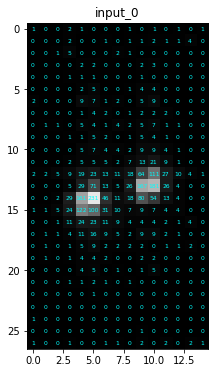

<Figure size 432x288 with 0 Axes>

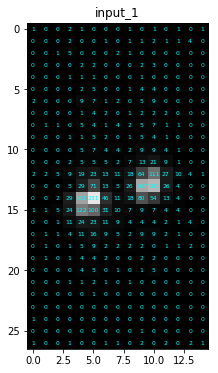

<Figure size 432x288 with 0 Axes>

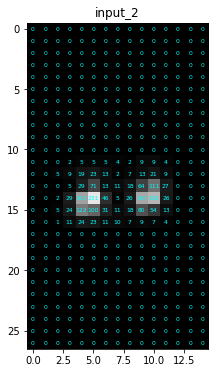

In [34]:
imgs = [im_a, im_b, im_c]
for i in range(len(imgs)):
    data = imgs[i]
    plt.clf()
    plt.figure(figsize=(6, 6))
    ax = plt.gca()
    plt.title("input_%s" % i)
    plt.imshow(data, cmap='gray', vmin=0, vmax=255)
    # Loop over data dimensions and create text annotations.
    for i in range(0, data.shape[0]):
        for j in range(0, data.shape[1]):
            text = ax.text(j, i, int(data[i, j]),
                           ha="center", va="center", color="cyan", fontsize=6)
    plt.savefig("input_" + str(i) + ".png", bbox_inches='tight')
    plt.show()

In [29]:
def normalize_blobs(blobs, new_len=50):
    new_count = new_len - blobs.shape[0]
    if new_count == 0:
        return blobs
    elif new_count > 0:
        temp = np.array([np.zeros((27, 15))] * new_count)
        return np.append(blobs, temp, axis=0)
    else:
        return blobs[0:new_len]

In [30]:
df_lstm_norm = df_lstm.copy(deep=True)
df_lstm_norm.Blobs = df_lstm_norm.Blobs.map(normalize_blobs)
lengths = []
for index, row in df_lstm_norm.iterrows():
    lengths.append(row.Blobs.shape[0])
df_lstm_norm["BlobCount"] = lengths
df_lstm_norm.BlobCount.describe()

count    8088.0
mean       50.0
std         0.0
min        50.0
25%        50.0
50%        50.0
75%        50.0
max        50.0
Name: BlobCount, dtype: float64

In [31]:
df_lstm_norm.to_pickle("PklData/df_lstm_norm50.pkl")

In [32]:
df_lstm_norm.head()

,userID,TaskID,VersionID,Blobs,BlobCount,GestureOnly
0,1,0,3,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",50,0
2,1,0,6,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",50,0
3,1,0,7,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",50,0
4,1,0,8,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0...",50,0
5,1,0,9,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 153...",50,0
